# IMPORT LIBRARY

In [2]:
import numpy as np #mengoperasikan array,vektor,matrix,perhitungan math
import pandas as pd #memproses data
import string

import matplotlib.pyplot as plt #visualisasi data
import seaborn as sns; sns.set() #menampilkan visualisasi grafik

import re #mencari karakter tertentu pada text
import nltk #untuk melakukan text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer #melakukan pembobotan TF-IDF
from sklearn.model_selection import KFold #membagi data train, data test
from sklearn.model_selection import GridSearchCV #mencari parameter terbaik
from sklearn.svm import SVC #pelatihan model dengan SVM

from jcopml.utils import save_model, load_model
from jcopml.plot import plot_classification_report, plot_confusion_matrix #evaluasi model

# IMPORT DATA

In [3]:
df = pd.read_csv("data_skripsi2.csv")
df.head()

date       usernamae sentimen  \
0  03/10/2020  polsekgumukmas   netral   
1  03/10/2020   jangkarpolsek   netral   
2  08/10/2020    humassemboro   netral   
3  08/10/2020   thinkpolicyid  negatif   
4  12/10/2020       bsmmedika   netral   

                                               tweet  
0  Pemenuhan kebutuhan vaksin dilakukan mulai akh...  
1  Keberadaannya Terancam Punah, 250.000 Hiu Dibu...  
2  Pemerintah menargetkan vaksin Covid-19 tersedi...  
3  Gimana kalo seandainya vaksin covid itu malah ...  
4  Pemerintah menyebutkan, pasokan vaksin COVID-1...

In [4]:
df.shape

(879, 4)

In [5]:
df.isna().sum()

date         0
usernamae    0
sentimen     0
tweet        0
dtype: int64

In [6]:
df['sentimen'].value_counts()

netral     368
positif    348
negatif    163
Name: sentimen, dtype: int64

# PREPROCESSING

In [7]:
def filtering(tweet):
    tweet = re.sub("(https:)\S+", "", tweet) #menghapus URL
    tweet = re.sub(r"(@)\S+", "", tweet) #menghapus akun
    tweet = re.sub(r"(#)\S+", "", tweet) #menghapus hashtag
    tweet = re.sub(r'\r\n', '', tweet) #menghapus enter
    tweet = re.sub(r'^a-zA-z0-9\s\?','', tweet) #menghapus karakter
    tweet = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", tweet) #menghapus simbol,angka, dan karakter aneh
    return tweet

df['tweet'] = df['tweet'].apply(filtering)
df.head()

date       usernamae sentimen  \
0  03/10/2020  polsekgumukmas   netral   
1  03/10/2020   jangkarpolsek   netral   
2  08/10/2020    humassemboro   netral   
3  08/10/2020   thinkpolicyid  negatif   
4  12/10/2020       bsmmedika   netral   

                                               tweet  
0  Pemenuhan kebutuhan vaksin dilakukan mulai akh...  
1  Keberadaannya Terancam Punah          Hiu Dibu...  
2  Pemerintah menargetkan vaksin Covid    tersedi...  
3  Gimana kalo seandainya vaksin covid itu malah ...  
4  Pemerintah menyebutkan  pasokan vaksin COVID  ...

In [8]:
def casefolding(x):
    x = " ".join(x.lower() for x in x.split())
    return x
df['tweet'] = df['tweet'].apply(casefolding)
df.head()

date       usernamae sentimen  \
0  03/10/2020  polsekgumukmas   netral   
1  03/10/2020   jangkarpolsek   netral   
2  08/10/2020    humassemboro   netral   
3  08/10/2020   thinkpolicyid  negatif   
4  12/10/2020       bsmmedika   netral   

                                               tweet  
0  pemenuhan kebutuhan vaksin dilakukan mulai akh...  
1  keberadaannya terancam punah hiu dibunuh demi ...  
2  pemerintah menargetkan vaksin covid tersedia d...  
3  gimana kalo seandainya vaksin covid itu malah ...  
4  pemerintah menyebutkan pasokan vaksin covid mu...

In [9]:
stopwords_indonesia = stopwords.words('indonesian')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_tweets(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    #remove coma
    tweet = re.sub(r',','',tweet)
    
    #remove angka
    tweet = re.sub('[0-9]+', '', tweet)

 # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_indonesia and # remove stopwords
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
             
    return tweets_clean

In [10]:
df['tweet_clean'] = df['tweet'].apply(lambda x: clean_tweets(x))
df.head()

date       usernamae sentimen  \
0  03/10/2020  polsekgumukmas   netral   
1  03/10/2020   jangkarpolsek   netral   
2  08/10/2020    humassemboro   netral   
3  08/10/2020   thinkpolicyid  negatif   
4  12/10/2020       bsmmedika   netral   

                                               tweet  \
0  pemenuhan kebutuhan vaksin dilakukan mulai akh...   
1  keberadaannya terancam punah hiu dibunuh demi ...   
2  pemerintah menargetkan vaksin covid tersedia d...   
3  gimana kalo seandainya vaksin covid itu malah ...   
4  pemerintah menyebutkan pasokan vaksin covid mu...   

                                         tweet_clean  
0                             [penuh, butuh, vaksin]  
1  [ada, ancam, punah, hiu, bunuh, dosis, vaksin,...  
2  [perintah, target, vaksin, covid, sedia, jangk...  
3  [gimana, kalo, anda, vaksin, covid, buruk, kal...  
4  [perintah, pasok, vaksin, covid, sedia, november]

In [11]:
def remove_punct(text):
    text  = " ".join([char for char in text if char not in string.punctuation])
    return text
df['tweet_preprocessing'] = df['tweet_clean'].apply(lambda x: remove_punct(x))
df.head()

date       usernamae sentimen  \
0  03/10/2020  polsekgumukmas   netral   
1  03/10/2020   jangkarpolsek   netral   
2  08/10/2020    humassemboro   netral   
3  08/10/2020   thinkpolicyid  negatif   
4  12/10/2020       bsmmedika   netral   

                                               tweet  \
0  pemenuhan kebutuhan vaksin dilakukan mulai akh...   
1  keberadaannya terancam punah hiu dibunuh demi ...   
2  pemerintah menargetkan vaksin covid tersedia d...   
3  gimana kalo seandainya vaksin covid itu malah ...   
4  pemerintah menyebutkan pasokan vaksin covid mu...   

                                         tweet_clean  \
0                             [penuh, butuh, vaksin]   
1  [ada, ancam, punah, hiu, bunuh, dosis, vaksin,...   
2  [perintah, target, vaksin, covid, sedia, jangk...   
3  [gimana, kalo, anda, vaksin, covid, buruk, kal...   
4  [perintah, pasok, vaksin, covid, sedia, november]   

                                 tweet_preprocessing  
0                                 penuh butuh vaksin  
1      ada ancam punah hiu bunuh dosis vaksin corona  
2  perintah target vaksin covid sedia jangkau mas...  
3  gimana kalo anda vaksin covid buruk kalo vaksi...  
4         perintah pasok vaksin covid sedia november

In [12]:
df = df[["tweet_preprocessing","sentimen"]]
df.head()

tweet_preprocessing sentimen
0                                 penuh butuh vaksin   netral
1      ada ancam punah hiu bunuh dosis vaksin corona   netral
2  perintah target vaksin covid sedia jangkau mas...   netral
3  gimana kalo anda vaksin covid buruk kalo vaksi...  negatif
4         perintah pasok vaksin covid sedia november   netral

In [13]:
df.to_csv('prepocessing_fix.csv')

# PEMBOBOTAN

In [14]:
df.sentimen.replace("positif", 1, inplace = True)
df.sentimen.replace("netral", 0, inplace = True)
df.sentimen.replace("negatif", -1, inplace = True)
df.sentimen= df.sentimen.apply(lambda x : int(x))
df.head()

tweet_preprocessing  sentimen
0                                 penuh butuh vaksin         0
1      ada ancam punah hiu bunuh dosis vaksin corona         0
2  perintah target vaksin covid sedia jangkau mas...         0
3  gimana kalo anda vaksin covid buruk kalo vaksi...        -1
4         perintah pasok vaksin covid sedia november         0

In [15]:
text = df['tweet_preprocessing']
df_tfidf = pd.DataFrame(text)
df_tfidf

tweet_preprocessing
0                                   penuh butuh vaksin
1        ada ancam punah hiu bunuh dosis vaksin corona
2    perintah target vaksin covid sedia jangkau mas...
3    gimana kalo anda vaksin covid buruk kalo vaksi...
4           perintah pasok vaksin covid sedia november
..                                                 ...
874  vaksinasi meni gkatkan daya tahan tubuh imunit...
875  nyata pp muhammadiyah vaksinasi covid ramadhan...
876                     besok vaksin jd takut jarum ya
877  oh iya besok dapet gilir jadwal vaksin deg an ...
878  satgas covid masyarakat khawatir kait aman sin...

[879 rows x 1 columns]

In [16]:
tfidf = TfidfVectorizer().fit(df_tfidf['tweet_preprocessing'])
count_tokens = tfidf.get_feature_names()
count_tokens

['aaayyyookk',
 'aamiin',
 'ab',
 'abal',
 'abang',
 'abdullah',
 'abis',
 'abraham',
 'acara',
 'acuh',
 'ada',
 'adisasmito',
 'adlh',
 'administrasi',
 'aduuuh',
 'afiat',
 'afrika',
 'again',
 'agama',
 'agen',
 'agenda',
 'agung',
 'agus',
 'ah',
 'ahirnya',
 'ahli',
 'ahmad',
 'aids',
 'aing',
 'air',
 'aja',
 'ajak',
 'ajar',
 'ak',
 'akal',
 'akan',
 'akeh',
 'akh',
 'akhir',
 'akhirmya',
 'akhirnyaa',
 'akibat',
 'akses',
 'aksi',
 'aktif',
 'aktifitas',
 'aktivitas',
 'aku',
 'akurat',
 'alam',
 'alami',
 'alamiah',
 'alas',
 'alcohol',
 'alesan',
 'alhamdu',
 'alhamdulilaah',
 'alhamdulilah',
 'alhamdulillaah',
 'alhamdulillah',
 'alhamdullilah',
 'alhamdullillah',
 'ali',
 'alive',
 'all',
 'allah',
 'allhamdulillah',
 'alokasi',
 'alumni',
 'am',
 'ama',
 'amaaand',
 'amal',
 'aman',
 'amanah',
 'ambil',
 'amburadul',
 'amerika',
 'amiiinn',
 'amiin',
 'amin',
 'amp',
 'ampuh',
 'ampun',
 'an',
 'anak',
 'ancam',
 'and',
 'anda',
 'andai',
 'andal',
 'andi',
 'android',
 '

In [17]:
tfidf_vect = tfidf.transform(df_tfidf['tweet_preprocessing'])

In [18]:
df_tfidf_vect = pd.DataFrame(data=tfidf_vect.toarray(),columns=count_tokens)
df_tfidf_vect

aaayyyookk  aamiin   ab  abal  abang  abdullah  abis  abraham  acara  \
0           0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
1           0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
2           0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
3           0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
4           0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
..          ...     ...  ...   ...    ...       ...   ...      ...    ...   
874         0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
875         0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
876         0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
877         0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   
878         0.0     0.0  0.0   0.0    0.0       0.0   0.0      0.0    0.0   

     acuh  ...  yoana  yogyakarta  yok  you  yra  yuk  yuukk  zaman  zona   zy  
0     0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
1     0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
2     0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
3     0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
4     0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
..    ...  ...    ...         ...  ...  ...  ...  ...    ...    ...   ...  ...  
874   0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
875   0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
876   0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
877   0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  
878   0.0  ...    0.0         0.0  0.0  0.0  0.0  0.0    0.0    0.0   0.0  0.0  

[879 rows x 2244 columns]

In [19]:
df_tfidf_vect.to_csv('tfidf_fix.csv')

# SPLITTING DATA

In [20]:
kf=KFold(n_splits=12, random_state=0, shuffle=True)
print(kf)  
i=1        
for train, test in kf.split(tfidf_vect):
    print("Fold ", i)
    print("TRAIN :", train, "TEST :", test)
    x_train=tfidf_vect[train]
    x_test=tfidf_vect[test]
    y_train=df['sentimen'][train]
    y_test=df['sentimen'][test]
    i+=1
print("shape x_train :", x_train.shape)
print("shape x_test :", x_test.shape)

KFold(n_splits=12, random_state=0, shuffle=True)
Fold  1
TRAIN : [  0   1   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  19
  20  21  22  23  24  25  26  28  29  30  32  33  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 143 146 147 148 149 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 194 195
 197 198 199 200 201 203 205 206 207 208 209 210 211 212 213 214 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 232 233 234 235 236 237
 238 240 241 242 243 244 245 246 247 248 249 250 251 252 25

# OPTIMASI PARAMETER

In [21]:
param_grid = {'C': [1, 10, 50], 
              'gamma': [0.1, 0.5, 1],
              'kernel': ['sigmoid']}

# PELATIHAN MODEL

In [22]:
model = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=12)
model.fit(x_train,y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 12 folds for each of 9 candidates, totalling 108 fits
{'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}
0.8957816377171216 0.6391937371963711 0.7123287671232876


In [23]:
df_grid = pd.DataFrame(model.cv_results_).sort_values('rank_test_score')
df_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
2       0.103722      0.015327         0.007729        0.001161       1   
3       0.119183      0.021724         0.010636        0.008869      10   
6       0.197309      0.069706         0.009471        0.002057      50   
4       0.135887      0.020829         0.007480        0.001255      10   
1       0.123835      0.020411         0.009059        0.001437       1   
7       0.214779      0.058479         0.009283        0.004031      50   
5       0.211599      0.081566         0.008895        0.002131      10   
8       0.151054      0.050962         0.006371        0.007551      50   
0       0.122921      0.018684         0.009640        0.002163       1   

  param_gamma param_kernel                                        params  \
2           1      sigmoid     {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}   
3         0.1      sigmoid  {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}   
6         0.1      sigmoid  {'C': 50, 'gamma': 0.1, 'kernel': 'sigmoid'}   
4         0.5      sigmoid  {'C': 10, 'gamma': 0.5, 'kernel': 'sigmoid'}   
1         0.5      sigmoid   {'C': 1, 'gamma': 0.5, 'kernel': 'sigmoid'}   
7         0.5      sigmoid  {'C': 50, 'gamma': 0.5, 'kernel': 'sigmoid'}   
5           1      sigmoid    {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}   
8           1      sigmoid    {'C': 50, 'gamma': 1, 'kernel': 'sigmoid'}   
0         0.1      sigmoid   {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}   

   split0_test_score  split1_test_score  ...  split5_test_score  \
2           0.529412           0.558824  ...           0.686567   
3           0.544118           0.573529  ...           0.686567   
6           0.544118           0.588235  ...           0.701493   
4           0.544118           0.573529  ...           0.671642   
1           0.544118           0.500000  ...           0.686567   
7           0.573529           0.602941  ...           0.656716   
5           0.514706           0.529412  ...           0.626866   
8           0.485294           0.514706  ...           0.582090   
0           0.411765           0.441176  ...           0.462687   

   split6_test_score  split7_test_score  split8_test_score  split9_test_score  \
2           0.626866           0.701493           0.746269           0.701493   
3           0.626866           0.671642           0.716418           0.716418   
6           0.567164           0.626866           0.716418           0.641791   
4           0.582090           0.626866           0.716418           0.656716   
1           0.597015           0.716418           0.701493           0.656716   
7           0.507463           0.626866           0.716418           0.611940   
5           0.537313           0.582090           0.597015           0.656716   
8           0.477612           0.582090           0.582090           0.641791   
0           0.477612           0.537313           0.507463           0.447761   

   split10_test_score  split11_test_score  mean_test_score  std_test_score  \
2            0.582090            0.626866         0.639194        0.063940   
3            0.582090            0.626866         0.637913        0.060156   
6            0.537313            0.626866         0.629189        0.061107   
4            0.537313            0.626866         0.624232        0.053491   
1            0.552239            0.567164         0.614373        0.066829   
7            0.597015            0.552239         0.609233        0.055444   
5            0.507463            0.611940         0.582035        0.047753   
8            0.582090            0.507463         0.557214        0.056195   
0            0.477612            0.462687         0.461626        0.034376   

   rank_test_score  
2                1  
3                2  
6                3  
4                4  
1                5  
7                6  
5                7  
8                8  
0                9  

[9 rows x 23 colu

# EVALUASI

In [24]:
model_pred = model.predict(x_test)
df_predict = pd.DataFrame()
df_predict['Hasil Prediksi Sentiment'] = model_pred
df_predict

Hasil Prediksi Sentiment
0                          0
1                          1
2                          0
3                          1
4                         -1
..                       ...
68                         0
69                         1
70                         1
71                         1
72                         0

[73 rows x 1 columns]

In [25]:
y_test

9      0
28     0
42     0
53    -1
70     1
      ..
835    0
845    1
846    1
849    1
862    1
Name: sentimen, Length: 73, dtype: int64

In [26]:
df_predict['Hasil Prediksi Sentiment'].value_counts()

 0    35
 1    32
-1     6
Name: Hasil Prediksi Sentiment, dtype: int64

In [27]:
plot_classification_report(x_train, y_train, x_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

          -1       0.94      0.84      0.89       149
           0       0.86      0.93      0.90       334
           1       0.91      0.88      0.90       323

    accuracy                           0.90       806
   macro avg       0.91      0.89      0.89       806
weighted avg       0.90      0.90      0.90       806


Test report
              precision    recall  f1-score   support

          -1       0.83      0.36      0.50        14
           0       0.71      0.74      0.72        34
           1       0.69      0.88      0.77        25

    accuracy                           0.71        73
   macro avg       0.75      0.66      0.67        73
weighted avg       0.73      0.71      0.70        73



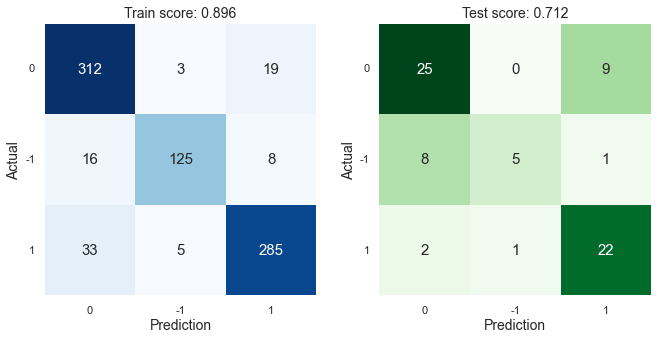

In [28]:
plot_confusion_matrix(x_train, y_train, x_test, y_test, model)

# VISUALISASI

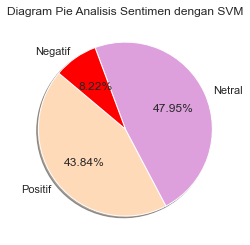

In [29]:
labels = ['Positif','Netral','Negatif']
Category1 = [32, 35, 6]
color = ['peachpuff', 'plum', 'red']
plt.pie(Category1, labels=labels, colors=color, startangle=140, shadow=True, autopct='%1.2f%%')
plt.title('Diagram Pie Analisis Sentimen dengan SVM')
plt.show()

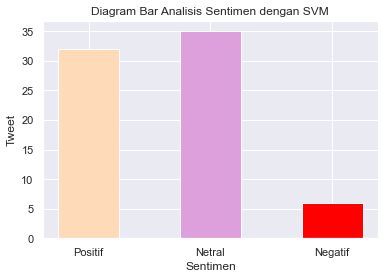

In [30]:
labels = ['Positif','Netral','Negatif']
Category1 = [32, 35, 6]
plt.bar(labels, Category1, tick_label=labels, width=0.5, color = ['peachpuff', 'plum', 'red'])
plt.xlabel('Sentimen')
plt.ylabel('Tweet')
plt.title('Diagram Bar Analisis Sentimen dengan SVM')
plt.show()

In [32]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p re,pandas,numpy,string,nltk,Sastrawi,sklearn,jcopml,matplotlib,seaborn

# date
print (" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.1
IPython version      : 7.25.0

re        : 2.2.1
pandas    : 1.3.0
numpy     : 1.21.1
string    : unknown
nltk      : 3.6.2
Sastrawi  : 1.0.1
sklearn   : 0.0
jcopml    : 1.1.10
matplotlib: 3.4.2
seaborn   : 0.11.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

 
Last updated: Wed Aug 18 2021 15:31:43SE Asia Standard Time

